# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Start of Week 1

## Table of contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion



## Introduction: Business Problem <a name="introduction"></a>

In this project we will identify the **best neighbourhood to open a supermarket in Edinburgh**. With COVID-19 imposing lockdowns throughout the world, and more people remaining at home, the demand for supermarkets is back on the rise, as one of the few physical activities that people can leave their homes to do. As such, supermarket chains should try to quickly expand in the near future to capture this added demand.

Specifically, this report will target **large supermarket chains such as Tesco and ASDA** by offering them a data-driven solution to the most profitable location to open their next outlet which will be best received by customers. Given that there are around **160** neighbourhoods in Edinburgh, this will greatly help supermarkets to limit the range of possible options and allow them to focus their efforts on researching areas within a potential cluster.

By clustering each neighbourhood by its facilities, we will **identify which clusters has "supermarket" and "grocery stores" listed as their top few locations**, as it is a strong indication of profitability. We will use our data science powers to first, generate a list of Edinburgh's 160 neighbourhoods. Second, to merge this list with location data from Foursquare. We will then use K-Means Clustering to cluster the 160 neighbourhoods.

## Data <a name="data"></a>

We first need to identify our list of neighbourhoods in Edinburgh cities. To do so:
* we need to scrape webpages of Edinburgh's neighbourhoods (Wikipedia)

Following data sources will be needed to extract/generate the required information:
* the GPS coordinates (latitude and longitude) of each neighbourhood (Geocoders)
* List of facilities around each neighbourhood (foursquare API)

#### Data(1) - Install Modules(A)

In [2]:
!pip install geocoder
!pip install lxml

     |████████████████████████████████| 102kB 6.9MB/s ta 0:00:011
     |████████████████████████████████| 92kB 6.0MB/s eta 0:00:011
     |████████████████████████████████| 829kB 9.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 5.5MB 5.0MB/s eta 0:00:01


#### Data(1) - Import Packages(B)

In [86]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
import lxml.html as lh
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



### Data(3) - Create Dataframe of Edinburgh's Neighbourhoods with Lat Long

#### Data(3A) - Extract Data from Wikipedia into CSV File

In [239]:
df = pd.read_csv('Sg.csv')
df

,Unnamed: 0,Neighbourhood
0,1,*[[Abbeyhill]]
1,2,*[[Alnwickhill]]
2,3,*[[Ardmillan]]
3,4,*[[Baberton]]
4,5,*[[Balerno]]
...,...,...
158,159,*[[West Pilton]]
159,160,*[[Wester Broom]]
160,161,*[[Wester Hailes]]
161,162,"*[[Western Harbour, Edinburgh|Western Harbour]]"


#### Data(3B) - Cleanup Data

In [240]:
df['Neighbourhood'] = [x.lstrip('*[').rstrip(']') for x in df['Neighbourhood']]
df[['First','Last']] = df.Neighbourhood.str.split("|",expand=True) 
df=df.drop(['Unnamed: 0', 'Neighbourhood', 'Last'], axis=1)
df.rename(columns={'First':'Neighbourhood'}, inplace=True)
df

,Neighbourhood
0,Abbeyhill
1,Alnwickhill
2,Ardmillan
3,Baberton
4,Balerno
...,...
158,West Pilton
159,Wester Broom
160,Wester Hailes
161,"Western Harbour, Edinburgh"


#### Data(3C) - Append Lat-Long into Dataframe + Save as CSV

In [39]:
#Code for appending lat-long

location = [x for x in df['Neighbourhood'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    # remove things that does not seem usefull here
    try:
        address = location[i] 
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(address)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the location, latitude and longitude
df1 = pd.DataFrame({'Neighbourhood':location, 
                    'location_latitude': latitude,
                    'location_longitude':longitude})
# merge on Neighbourhood with df to get the column 
df2 = df.merge(df1, on='Neighbourhood', how='left')
df2.to_csv('Sg0.csv')

The geographical coordinate of location are 55.9554774, -3.1705852.
The geographical coordinate of location are 55.9060866, -3.1725479.
The geographical coordinate of location are 55.9384662, -3.2252298.
The geographical coordinate of location are 55.9098035, -3.2888689.
The geographical coordinate of location are 55.8839143, -3.3387606.
The geographical coordinate of location are 55.9403856, -3.2556387.
The geographical coordinate of location are 55.9249188, -3.2978516.
The geographical coordinate of location are 55.9641918, -3.2937059.
The geographical coordinate of location are 52.7132545, -6.5152238.
The geographical coordinate of location are 55.9519018, -3.1904199.
The geographical coordinate of location are 55.9396128, -3.1228728.
The geographical coordinate of location are 55.9282187, -3.190603.
The geographical coordinate of location are 55.9575319, -3.2580527.
The geographical coordinate of location are 55.9008967, -3.2583444.
The geographical coordinate of location are 55.90

#### Data(3D) - Tidied up inaccurate Lat-Longs (extracted from Geocoder) using Editor

In [241]:
df2=pd.read_csv('Sg1.csv')
df2=df2.drop(['Unnamed: 0'], axis=1)
df2

,Neighbourhood,location_latitude,location_longitude
0,Abbeyhill,55.955477,-3.170585
1,Alnwickhill,55.906087,-3.172548
2,Ardmillan,55.938466,-3.225230
3,Baberton,55.909804,-3.288869
4,Balerno,55.883914,-3.338761
...,...,...,...
158,West Pilton,55.971052,-3.245955
159,Wester Broom,55.936230,-3.291196
160,Wester Hailes,55.915225,-3.284488
161,"Western Harbour, Edinburgh",55.984005,-3.180893


#### Data(3E) - Ensure accuracy by mapping out Neighbourhoods

In [6]:
map_edin = folium.Map(location=[55.9533,-3.1883], zoom_start=11)

# add markers to map
for lat, lng, Neighbourhood in zip(df2['location_latitude'], df2['location_longitude'], df2['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edin)  
    
map_edin

### Data(4) - Venue Data for Each Neighbourhood

#### Data(4A) - Foursquare Credentials

In [7]:
CLIENT_ID = 'NSORKPHBIOMJTE5V0S2D3TUB1XEUIR02T53XLNM4HX30XCYS' # your Foursquare ID
CLIENT_SECRET = 'LLFBS34PAR2VUU1VI5QITYWGHHZ2NWX3RAQAG2MKUTNIKEJR' # your Foursquare Secret
VERSION = '20201706'

#### Data(4B) - Using Foursquare API on all neighbourhoods

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL for Arts and Entertainment
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
  
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [59]:
edin_venues = getNearbyVenues(names=df2['Neighbourhood'],
                                   latitudes=df2['location_latitude'],
                                   longitudes=df2['location_longitude']
                                  )


Abbeyhill
Alnwickhill
Ardmillan
Baberton
Balerno
Balgreen
Bankhead, Edinburgh
Barnton, Edinburgh
Beechmount
Bellevue, Edinburgh
Bingham, Edinburgh
Blackford, Edinburgh
Blackhall, Edinburgh
Bonaly
Bonnington, Edinburgh
Burghmuirhead
Braepark, Edinburgh
Broomhouse
Broughton, Edinburgh
Brunstane
Bruntsfield
Bughtlin
Burdiehouse
The Calders
Cameron Toll
Cammo
The Canongate
Canonmills
Chesser
Church Hill, Edinburgh
Clermiston
Colinton
Comely Bank
Comiston
Corstorphine
Cowgate
Clovenstone
Craigcrook
Craigentinny
Craigievar Estate
Craigleith, Edinburgh
Craiglockhart
Craigmillar
Craigour
Cramond
Crewe Toll
Currie
Curriehill
Dalmeny
Dalmahoy
Dalry, Edinburgh
Davidson's Mains
Dean Village
Drumbrae
Drylaw
Duddingston
Dumbiedykes
East Craigs
East Pilton
Eastfield, Edinburgh
Edinburgh Park
Fairmilehead
Ferniehill
Fernieside
Ferry Road
Firrhill
Forrester, Edinburgh
Fountainbridge
Gilmerton
Gogar
Gogarloch
Goldenacre
Gorgie
The Grange, Edinburgh
Grassmarket
Granton, Edinburgh
Greenbank, Edinburgh
Gre

## End of Week 1
## Start of Week 2

## Methodology

In [61]:
print(edin_venues.shape)
print('There are {} uniques categories.'.format(len(edin_venues['Venue_Category'].unique())))
edin_venues.groupby('Neighborhood').count()

(5245, 7)
There are 248 uniques categories.


,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Neighborhood,,,,,,
Abbeyhill,71,71,71,71,71,71
Alnwickhill,7,7,7,7,7,7
...,...,...,...,...,...,...
"Western Harbour, Edinburgh",39,39,39,39,39,39
"Westfield, Edinburgh",1,1,1,1,1,1


## Analyse each neighbourhood for top 10 venues

In [62]:
# one hot encoding
edin_onehot = pd.get_dummies(edin_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
edin_onehot['Neighborhood'] = edin_venues['Neighborhood'] 

#Move neighborhood column to the front
N1 = edin_onehot['Neighborhood']
edin_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
edin_onehot.insert(0, 'Neighborhood', N1)
edin_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,...,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Abbeyhill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbeyhill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbeyhill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbeyhill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abbeyhill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
edin_grouped = edin_onehot.groupby('Neighborhood').mean().reset_index()
edin_grouped

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,...,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Abbeyhill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Alnwickhill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,"Western Harbour, Edinburgh",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0
160,"Westfield, Edinburgh",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [215]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = edin_grouped['Neighborhood']

for ind in np.arange(edin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(edin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbeyhill,Café,Bar,Grocery Store,Park,Bakery,Hotel,Pub,Liquor Store,Coffee Shop,Restaurant
1,Alnwickhill,Furniture / Home Store,Pub,English Restaurant,Golf Driving Range,Park,Sporting Goods Shop,Hotel,Food Court,Food & Drink Shop,Electronics Store
2,Ardmillan,Hotel,Pub,Coffee Shop,Grocery Store,Café,Chinese Restaurant,Supermarket,Italian Restaurant,Pizza Place,Convenience Store
3,Baberton,Train Station,Discount Store,Supermarket,Golf Course,Bakery,Auto Garage,Multiplex,Dessert Shop,Diner,Furniture / Home Store
4,Balerno,Grocery Store,Rugby Pitch,Pub,Zoo Exhibit,Forest,Food Truck,Food Court,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant


## Set Dataframe for K Means to work on

In [66]:
edin_grouped_clustering = edin_grouped.drop('Neighborhood', 1)
edin_grouped_clustering.head()

,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
edin_grouped_clustering_norm = StandardScaler().fit_transform(edin_grouped_clustering)
edin_grouped_clustering_norm

array([[-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ],
       [-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ],
       [-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ],
       ...,
       [-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ],
       [-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ],
       [-0.07905694, -0.32238937, -0.11113166, ..., -0.07905694,
        -0.11009771, -0.1017671 ]])

## Using K-Means Clustering

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(3, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(3, x))
    plt.show()

In [181]:
max_range = 20 # Maximum range of clusters

In [182]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(3, max_range) :
    
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(edin_grouped_clustering_norm)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(edin_grouped_clustering_norm, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

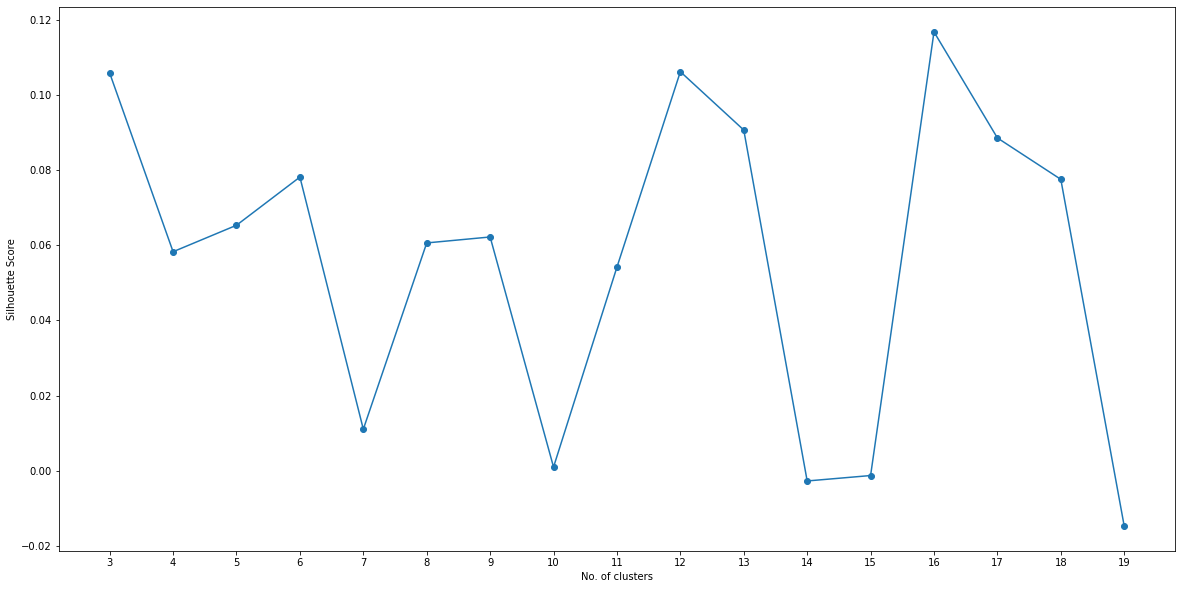

In [187]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [212]:
opt = np.argmax(scores) + 3 # Finds the optimal number of Clusters
opt

16

## K-means clustering for 16 clusters

In [214]:
#Cluster Neighborhoods
# set number of clusters
kclusters = 16

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(edin_grouped_clustering_norm)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:162] 

array([ 7,  2,  2,  2,  2, 11,  2,  2,  7,  2, 12,  2,  2,  2,  2,  2,  7,
        9,  0,  2,  2,  2,  2,  7, 15,  0,  2,  2,  2, 13,  2,  2,  1,  2,
        2,  9, 13, 15,  2,  2,  2,  2,  2,  2,  2,  2,  8,  2,  3,  2,  2,
        2,  5,  2,  2,  2,  9,  2,  2,  2,  2,  2,  2,  8,  2,  2,  9,  2,
       11,  2,  1,  2,  2,  0,  8,  2,  0,  2,  5,  2,  4,  2,  2,  2,  2,
        2, 15,  2,  1,  7,  2,  2,  2,  8, 15,  0,  9,  7,  7,  7,  2,  2,
        2,  2,  2, 11,  6,  7,  9, 10,  7,  9,  2,  7,  2,  2,  2,  2,  7,
        2,  7,  2,  7,  2,  7,  2, 11,  2,  2,  2, 11,  2,  7,  2,  2,  2,
        2, 15,  9,  2,  2, 13,  2,  2,  5,  7,  1,  1,  2, 10,  4,  7,  2,
        8,  9,  3,  2,  2,  2, 14,  2], dtype=int32)

In [216]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [217]:
edin_merged = df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
edin_merged = edin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

In [218]:
edin_merged.dropna(inplace = True)
edin_merged = edin_merged.astype({"Cluster Labels": int})

In [219]:
#Create map of clusters
address = 'Edinburgh, United Kingdom'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Edinburgh are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Edinburgh are 55.9533456, -3.1883749.


In [220]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edin_merged['location_latitude'], edin_merged['location_longitude'], edin_merged['Neighbourhood'], edin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## 5. Examine Clusters

### Cluster 1

In [221]:
edin_merged.loc[edin_merged['Cluster Labels'] == 0, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Bruntsfield,Coffee Shop,Pub,Grocery Store,Café,Hotel,Restaurant,Italian Restaurant,Park,Movie Theater,Bakery
29,"Church Hill, Edinburgh",Coffee Shop,Pub,Café,Grocery Store,Italian Restaurant,Bakery,Restaurant,Fish & Chips Shop,Park,Sandwich Place
78,"Greenhill, Edinburgh",Coffee Shop,Pub,Grocery Store,Café,Bar,Indian Restaurant,Restaurant,Italian Restaurant,Bakery,Sandwich Place
81,Holy Corner,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Café,Pizza Place,Indian Restaurant,Restaurant,Hotel,Bakery
100,Marchmont,Coffee Shop,Café,Italian Restaurant,Bakery,Pub,Restaurant,Grocery Store,Hotel,Movie Theater,Park


### Cluster 2

In [222]:
edin_merged.loc[edin_merged['Cluster Labels'] == 1, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Cowgate,Café,Hotel,Restaurant,Museum,Bar,Pub,Coffee Shop,Art Gallery,Gastropub,Indian Restaurant
74,Grassmarket,Café,Coffee Shop,Hotel,Park,Museum,Beer Bar,Scottish Restaurant,Seafood Restaurant,Cocktail Bar,Theater
93,Lauriston,Park,Restaurant,Café,Hotel,Coffee Shop,Theater,Pub,Museum,Beer Bar,Scottish Restaurant
104,The Meadows (park),Pub,Restaurant,Café,Museum,Beer Bar,Scottish Restaurant,Coffee Shop,Park,Indian Restaurant,Theater
149,"Tollcross, Edinburgh",Hotel,Café,Pub,Coffee Shop,Sandwich Place,Park,Restaurant,Scottish Restaurant,Theater,Bar


### Cluster 3

In [223]:
edin_merged.loc[edin_merged['Cluster Labels'] == 2, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alnwickhill,Furniture / Home Store,Pub,English Restaurant,Golf Driving Range,Park,Sporting Goods Shop,Hotel,Food Court,Food & Drink Shop,Electronics Store
2,Ardmillan,Hotel,Pub,Coffee Shop,Grocery Store,Café,Chinese Restaurant,Supermarket,Italian Restaurant,Pizza Place,Convenience Store
3,Baberton,Train Station,Discount Store,Supermarket,Golf Course,Bakery,Auto Garage,Multiplex,Dessert Shop,Diner,Furniture / Home Store
4,Balerno,Grocery Store,Rugby Pitch,Pub,Zoo Exhibit,Forest,Food Truck,Food Court,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant
6,"Bankhead, Edinburgh",Hotel,Tram Station,Coffee Shop,Clothing Store,Supermarket,Platform,Breakfast Spot,Bakery,Shopping Plaza,Motorcycle Shop
...,...,...,...,...,...,...,...,...,...,...,...
154,Warriston,Coffee Shop,Café,Garden,Park,Bakery,Restaurant,Italian Restaurant,Botanical Garden,Breakfast Spot,Scottish Restaurant
158,West Pilton,Park,Hotel,Soccer Field,Shopping Plaza,Bakery,Café,Gym,Gym / Fitness Center,Pizza Place,Coffee Shop
159,Wester Broom,Grocery Store,Bus Stop,Pub,Hotel,Gym,Shopping Plaza,Cafeteria,English Restaurant,Gastropub,Supermarket
160,Wester Hailes,Supermarket,Multiplex,Sandwich Place,Golf Course,Discount Store,Train Station,Food & Drink Shop,Fish & Chips Shop,Food Court,Electronics Store


### Cluster 4

In [224]:
edin_merged.loc[edin_merged['Cluster Labels'] == 3, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Dean Village,Hotel,Bar,Café,Pub,Restaurant,Coffee Shop,Sandwich Place,French Restaurant,Pizza Place,Italian Restaurant
157,"West End, Edinburgh",Bar,Hotel,Sandwich Place,French Restaurant,Pub,Italian Restaurant,Pizza Place,Beer Bar,Café,Coffee Shop


### Cluster 5

In [225]:
edin_merged.loc[edin_merged['Cluster Labels'] == 4, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,Ingliston,Rental Car Location,Hotel,Airport Terminal,Coffee Shop,Bookstore,Tram Station,Grocery Store,Donut Shop,Airport Lounge,Pharmacy
152,Turnhouse,Rental Car Location,Airport Terminal,Hotel,Airport Lounge,Cosmetics Shop,Coffee Shop,Fast Food Restaurant,Seafood Restaurant,Electronics Store,Bookstore


### Cluster 6

In [226]:
edin_merged.loc[edin_merged['Cluster Labels'] == 5, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,The Canongate,Hotel,Café,Bar,Restaurant,Museum,Pub,Coffee Shop,Indian Restaurant,Whisky Bar,Art Gallery
56,Dumbiedykes,Hotel,Pub,Café,Restaurant,Bar,Museum,Park,Coffee Shop,Gastropub,Art Gallery
82,"Holyrood, Edinburgh",Café,Bar,Hotel,Pub,Park,Restaurant,Art Gallery,Bakery,Theater,Beer Bar


### Cluster 7 

In [229]:
edin_merged.loc[edin_merged['Cluster Labels'] == 6, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
112,"New Town, Edinburgh",Café,Bar,Coffee Shop,Park,Cocktail Bar,Pub,Whisky Bar,Hotel,French Restaurant,Restaurant


### Cluster 8

In [230]:
edin_merged.loc[edin_merged['Cluster Labels'] == 7, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbeyhill,Café,Bar,Grocery Store,Park,Bakery,Hotel,Pub,Liquor Store,Coffee Shop,Restaurant
9,"Bellevue, Edinburgh",Coffee Shop,Café,Hotel,Cocktail Bar,Sandwich Place,French Restaurant,Museum,Park,Pub,Beer Bar
18,"Broughton, Edinburgh",Bar,Pub,Bakery,Italian Restaurant,Hotel,Café,Coffee Shop,Grocery Store,Restaurant,Chinese Restaurant
27,Canonmills,Café,Pub,Bar,Coffee Shop,Bakery,Hotel,Deli / Bodega,Park,Cocktail Bar,Italian Restaurant
73,"The Grange, Edinburgh",Pub,Café,Coffee Shop,Bar,Hotel,Bed & Breakfast,Pool,Grocery Store,Restaurant,Chinese Restaurant
94,Leith,Bar,Hotel,Pub,Café,Seafood Restaurant,Coffee Shop,French Restaurant,Deli / Bodega,Pizza Place,Italian Restaurant
102,"Mayfield, Edinburgh",Hotel,Pub,Restaurant,Coffee Shop,Bar,Bakery,Café,Performing Arts Venue,Pizza Place,Deli / Bodega
103,"Meadowbank, Edinburgh",Café,Park,Grocery Store,Hotel,Soccer Stadium,Bar,Art Gallery,Supermarket,Clothing Store,Shopping Plaza
105,Merchiston,Coffee Shop,Pub,Grocery Store,Café,Pizza Place,Hotel,Indian Restaurant,Park,Italian Restaurant,Chinese Restaurant
113,"Newbridge, Edinburgh",Furniture / Home Store,Arts & Crafts Store,Bakery,Hotel,Business Service,Heliport,Go Kart Track,Zoo Exhibit,Farm,Farmers Market


### Cluster 9

In [231]:
edin_merged.loc[edin_merged['Cluster Labels'] == 8, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,"Dalry, Edinburgh",Hotel,Pub,Grocery Store,Coffee Shop,Café,Bar,Indian Restaurant,Pizza Place,Convenience Store,Chinese Restaurant
67,Fountainbridge,Pub,Italian Restaurant,Coffee Shop,Café,Hotel,Restaurant,Sandwich Place,Bar,Theater,French Restaurant
79,"Haymarket, Edinburgh",Hotel,Pub,Bar,Italian Restaurant,Café,Sandwich Place,Restaurant,Beer Bar,Wine Bar,African Restaurant
98,Lochrin,Pub,Hotel,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Restaurant,Bar,Theater,French Restaurant
155,West Coates,Hotel,Pub,Grocery Store,Indian Restaurant,Café,Bar,Italian Restaurant,Trail,Deli / Bodega,Restaurant


### Cluster 10

In [232]:
edin_merged.loc[edin_merged['Cluster Labels'] == 9, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Brunstane,Clothing Store,Coffee Shop,Hotel,Furniture / Home Store,Restaurant,Fast Food Restaurant,Beach,Chocolate Shop,Supermarket,Bookstore
39,Craigievar Estate,Coffee Shop,Bus Stop,Hotel,Indian Restaurant,Clothing Store,Café,Supermarket,Sporting Goods Shop,Massage Studio,Fast Food Restaurant
60,Edinburgh Park,Hotel,Tram Station,Coffee Shop,College Football Field,Clothing Store,Donut Shop,Shopping Plaza,Cafeteria,Fast Food Restaurant,Office
70,Gogarloch,Coffee Shop,Hotel,Clothing Store,Supermarket,Sporting Goods Shop,Food Court,Bus Stop,Mobile Phone Shop,Cafeteria,Shopping Plaza
101,Maybury,Coffee Shop,Hotel,Clothing Store,Sandwich Place,Gym,Mobile Phone Shop,Café,Discount Store,Toy / Game Store,Food Court
114,Newcraighall,Clothing Store,Coffee Shop,Pizza Place,Hotel,Electronics Store,Mobile Phone Shop,Burger Joint,Multiplex,Fast Food Restaurant,Optical Shop
117,"Niddrie, Edinburgh",Clothing Store,Supermarket,Bookstore,Coffee Shop,Toy / Game Store,Fast Food Restaurant,Café,Burger Joint,Sandwich Place,Chocolate Shop
144,South Gyle,Coffee Shop,Bus Stop,Clothing Store,Hotel,Gym / Fitness Center,Shoe Store,Sandwich Place,Chinese Restaurant,Restaurant,Optical Shop
156,West Craigs,Hotel,Clothing Store,Coffee Shop,Sandwich Place,Gym,Mobile Phone Shop,Café,Discount Store,Toy / Game Store,Food Court


### Cluster 11

In [233]:
edin_merged.loc[edin_merged['Cluster Labels'] == 10, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
115,"Newhaven, Edinburgh",Hotel,Café,Park,Supermarket,Grocery Store,Clothing Store,Food & Drink Shop,Sandwich Place,Bike Trail,Street Food Gathering
151,"Trinity, Edinburgh",Pub,Park,Hotel,Café,Food & Drink Shop,Rugby Pitch,Bike Trail,Supermarket,Climbing Gym,Trail


### Cluster 12

In [234]:
edin_merged.loc[edin_merged['Cluster Labels'] == 11, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Balgreen,Hotel,Grocery Store,Bus Stop,Zoo Exhibit,Sports Bar,Furniture / Home Store,Skating Rink,Gastropub,Skate Park,Café
72,Gorgie,Pub,Coffee Shop,Park,Grocery Store,Supermarket,Hotel,Tram Station,Sports Bar,Fast Food Restaurant,Bowling Green
111,Murrayfield,Hotel,Sports Bar,Tram Station,Grocery Store,School,Park,Gastropub,Golf Course,Skating Rink,Furniture / Home Store
132,Ravelston,Hotel,Pharmacy,Electronics Store,Supermarket,Convenience Store,Sporting Goods Shop,Fast Food Restaurant,Skating Rink,Shopping Plaza,Café
136,Roseburn,Hotel,Grocery Store,Pub,Café,Italian Restaurant,Art Gallery,Pharmacy,Sports Bar,Tram Station,Coffee Shop


### Cluster 13

In [235]:
edin_merged.loc[edin_merged['Cluster Labels'] == 12, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Blackford, Edinburgh",Pub,Coffee Shop,Café,Planetarium,Scenic Lookout,Lake,Bakery,Pool,Cupcake Shop,Restaurant


### Cluster 14

In [236]:
edin_merged.loc[edin_merged['Cluster Labels'] == 13, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Comely Bank,Café,Hotel,Restaurant,Park,Pub,Art Gallery,Coffee Shop,Farmers Market,Gastropub,Thai Restaurant
40,"Craigleith, Edinburgh",Café,Hotel,Restaurant,Pub,Bar,Coffee Shop,Art Gallery,Pizza Place,Deli / Bodega,Park
147,"Stockbridge, Edinburgh",Café,Bar,Hotel,Coffee Shop,Park,Cocktail Bar,Bakery,Restaurant,Pub,Garden


### Cluster 15

In [237]:
edin_merged.loc[edin_merged['Cluster Labels'] == 14, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
161,"Western Harbour, Edinburgh",Hotel,Café,Grocery Store,Italian Restaurant,Pharmacy,Pub,Supermarket,Boat or Ferry,Bookstore,Men's Store


### Cluster 16

In [238]:
edin_merged.loc[edin_merged['Cluster Labels'] == 15, edin_merged.columns[[0] + list(range(4, edin_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Chesser,Supermarket,Grocery Store,Gas Station,Auto Garage,Soccer Field,Bowling Alley,Fast Food Restaurant,Market,Tourist Information Center,Chinese Restaurant
41,Craiglockhart,Soccer Field,Stadium,Supermarket,Trail,Grocery Store,Gas Station,Tennis Court,Coffee Shop,Fast Food Restaurant,Market
91,Kingsknowe,Trail,Gas Station,Chinese Restaurant,Supermarket,Market,Train Station,Deli / Bodega,Department Store,Fountain,Forest
99,"Longstone, Edinburgh",Supermarket,Museum,Fast Food Restaurant,Tourist Information Center,Market,Trail,Train Station,Chinese Restaurant,Grocery Store,Gym
143,Slateford,Grocery Store,Supermarket,Coffee Shop,Trail,Gym / Fitness Center,Bowling Alley,Soccer Field,Fast Food Restaurant,Nature Preserve,Gas Station
